# Exercise 1 - Protein in Water

You can run this example directly in your browser: [![Open On Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sef43/openmm_workshop/blob/exercise_1/exercise_1.ipynb)


## Introduction

We will cover the following steps:
- Load a PDB file into OpenMM
- Choose the force-field
- Solvate the protein with water and ions
- Setup system and integrator
- Run local minimization
- Run NVT equilibration
- Run NPT production molecular dynamics
- Basic analysis
- How to use checkpoints


## Download the protein structure file

We will download the file from the workshop github repo

In [1]:
#!wget TODO

## Load the PDB file into OpenMM

First we need to import OpenMM.
We then then load in the PDB file/

In [2]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

# load in the pdb file
pdb = PDBFile('villin.pdb')

## Define the forcefield

We need to define the forcefield we want to use. We will use the Amber14 forcefield and the TIP3P-FB water model.

In [3]:

# Specify the forcefield 
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')


## Solvate 

We can use the `Modeller` class to solvate the protein in waterbox.

In [4]:


# create a Modeller object
modeller = Modeller(pdb.topology, pdb.positions)


# Solvate the protein in a box of water
modeller.addSolvent(forcefield, padding=1.0*nanometer)


This command creates a box that has edges at least 1nm away from the solute and fills it with water molecules. Additionally it adds in the required number of CL and Na ions to make the system charge neutral.

## Setup system and Integrator

We now need to combine our molecular topology and the forcefield to create a complete description of the system. This is done using the `ForceField` object’s `createSystem()` function. We then create the integrator, and combine the integrator and system to create the Simulation object. Finally we set the initial atomic positions.

In [5]:

# Create a system. Here we define some forcefield settings such as the nonbonded method
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)

# Define the integrator. The Langevin integrator is also a thermostat
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)



## Local energy minimization

It is a good idea to run local energy minimization at the start of a simulation because the coordinates in starting configuration file might produce very large forces.

In [6]:

print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


## Setup reporting

To get output from our simulation we can add reporters. We use `DCDReporter` to write the coordinates every 1000 timesteps to 'traj.dcd' and we use `StateDataReporter` to print the timestep, potential energy, temperature, and volume to the screen and to a file called 'md_log.txt'.

In [7]:


# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000))

# Print state information to teh screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))


## NVT equilibration
We are using a Langevin integrator which means we are simulating in the NVT ensemble. To equilibrate the temperature we just need to run the simulation for a number of timesteps.

In [8]:

print('Running NVT')
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-108829.8638225944,293.49776109938915,75.907156543232
2000,-107430.5845257194,305.92648391060493,75.907156543232
3000,-107808.6919475944,304.6142102603714,75.907156543232
4000,-107814.8677288444,307.50378889750715,75.907156543232
5000,-108281.8345257194,298.57592669503504,75.907156543232
6000,-107913.8110882194,306.7512500190366,75.907156543232
7000,-107413.0884319694,303.4943680256904,75.907156543232
8000,-107664.3208538444,304.49517378597994,75.907156543232
9000,-107700.1763225944,304.02260518629663,75.907156543232
10000,-107541.0317913444,301.40777736778324,75.907156543232


## NPT production MD

To run our simulation in the NPT ensemble we need to add in a barostat to control the pressure. We can use MonteCarloBarostat.

In [9]:

system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

# It is important to call the reinitialize method on the simulation 
# otherwise the modifications will not be applied.
simulation.context.reinitialize(preserveState=True)

print('Running NPT')
simulation.step(10000)


Running NPT
11000,-108200.89425914717,298.21914937421593,75.84002403440515
12000,-108935.60320120893,305.5489276689041,74.93142344855798
13000,-109035.01530249364,302.97404335513806,73.38215824617633
14000,-108994.77353060292,307.23850990220706,71.64163610837335
15000,-109470.2504380694,304.7136415592384,71.1231481025294
16000,-109455.57042341412,299.1791900605021,70.01366196218206
17000,-109656.94721907453,298.3138989180592,70.14441409793736
18000,-109744.13275099557,303.3025745798689,69.33767102540773
19000,-109241.90956945426,297.1579744012866,69.29967351252151
20000,-109987.92289719445,302.8932853758754,69.36712818193739


## Analysis

We can now do some basic analysis using Python. We will plot the time evolution of the potential energy, temperature, and box volume. Remember that OpenMM itself is primarily an MD engine, for in-depth analysis of your simulations you can use other python packages such as MDtraj, or MDAnalysis.


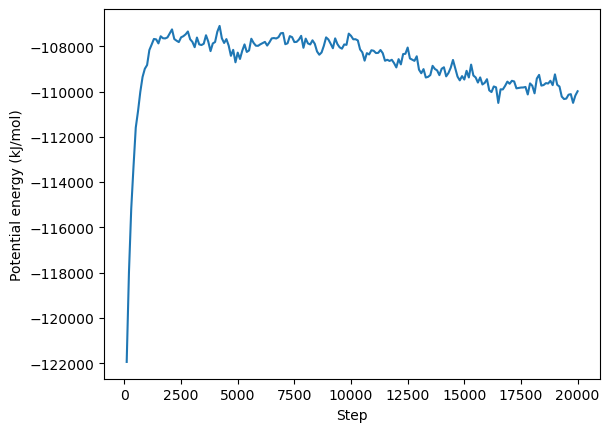

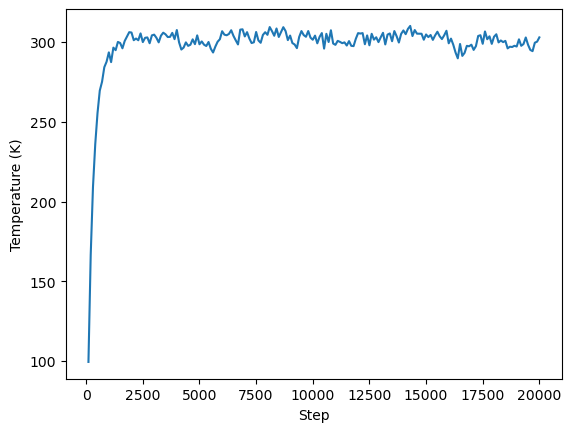

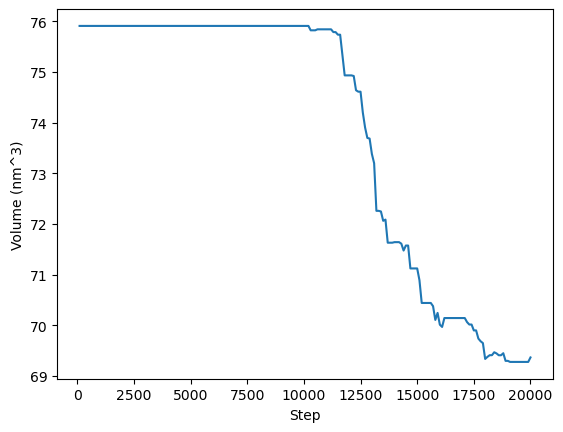

In [10]:

import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('md_log.txt', delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()

## Checkpointing

When you run long simulations it is useful to be able to save checkpoints. This means you can restart them in the case of a crash. Or it means you can resume them if you need to fit within the time constraints of a HPC job scheduler.

To run a resume a simulation we need to have three files saved to disk that we can load in:
1. The topology - this will be a PDB file of our solvated system. 
2. A serialized `System` -  this is an xml file that contains the forcefield settings.
3. A checkpoint file - this is a binary file that contains the positions, velocities, and box vectors
The first two only need to be saved once, they are constant throughout the simulation. The checkpoint needs to be 
saved after a specified number of timesteps. 


## Setup the checkpoint

We will create the topology and serialized system files. And we will use `CheckpointReporter` to regularly create checkpoint files.

In [11]:


# Save the toplogy as a PDB file
with open('topology.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(),output)

# save a serialized version of the system. This stores the forcefield parameters
with open('system.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


## Running for a set time limit

We now run for a set amount of wall clock time (30 seconds) and save checkpoint every 1000 steps

In [12]:


# run for 30 seconds
simulation.runForClockTime(30.0*seconds)

21000,-109814.99531971896,296.51661101544016,69.37862766466398
22000,-109959.48823547113,309.0062956165403,68.96181132061967
23000,-109950.43343996722,305.55342213514695,69.32754584108459
24000,-109685.95228557882,300.6893068335541,69.38467345943957
25000,-110128.7025649363,302.84507416502953,69.3089782858309
26000,-110013.82383842045,296.86969107524504,68.59273435811102
27000,-110201.61922854494,303.5885433623158,68.8221984136086
28000,-110325.35968538554,306.7375161449782,68.87620682567963
29000,-110251.0103113791,294.6746172458693,69.11087395559744
30000,-109900.96510781173,302.80987123827634,69.43312371724345
31000,-109622.50611643115,297.41177270382406,69.37875718917385
32000,-110086.79059463943,308.12498506006733,69.39422051423759
33000,-109379.15162404883,299.2768139187796,69.57341750088598
34000,-109654.77003911982,296.2829314063099,69.18473885686016
35000,-109539.57969048503,300.97847516270764,69.12489184757796
36000,-109662.16621069814,299.34933604266587,69.31626623919944
370

## Resume from a checkpoint

We now have the required files 'topology.pdb', 'system.xml', and 'checkpoint.chk'. We will need to load them in so we can resume the simulation from the last checkpoint. Note that we have to define the integrator again as well as the simulation reporters. Furthermore we have set the `append=True` flag to the DCD and StateData reporters.

In [13]:


pdb = PDBFile('topology.pdb')

with open('system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

# Define the integrator.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(pdb.topology, system, integrator)

# set the positions, velocities, and box vectors from the checkpoint file
simulation.loadCheckpoint('checkpoint.chk')

# We still need to define the reporters again

# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))


# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

# run for 30 seconds
simulation.runForClockTime(30.0*seconds)



#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
47000,-109771.07674168039,298.36459809426253,69.5958672141375
48000,-109712.33073309029,297.59601980921315,69.4388399588184
49000,-109957.47803757462,303.90121282996074,69.06367677392066
50000,-109353.57956291322,297.21065657946866,69.374750380204
51000,-109687.34721499815,300.921188570356,68.97325349135184
52000,-110171.03769254143,300.56284201006144,68.98016238743932
53000,-109908.24035417021,305.6583977639487,69.15752018071854
54000,-109748.24159149319,303.4944318184041,69.28982144701321
55000,-110131.79236122814,305.20824435226854,69.32980126814736
56000,-109258.55132027972,302.43627415745857,69.52967339729918
57000,-110097.39803947369,304.56472074496185,68.98680867961899
58000,-109711.64134730358,302.65121689988,68.82616071073825
59000,-110154.67730473774,296.89641545383284,68.98572797863675
60000,-109424.60912939755,303.7590103148094,68.99628350920277
61000,-110015.90834897524,309.6412272057241,69.25415935

## Resume multiple times

We can emulate doing multiple resumes, i.e. you would do this when you have to adhere to the time limits of a HPC
job scheduler.

In [14]:

for i in range(3):
    print("Resuming from checkpoint iteration = ", i)

    pdb = PDBFile('topology.pdb')

    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
            potentialEnergy=True, temperature=True, volume=True))
    
    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    
    # run for 30 seconds
    simulation.runForClockTime(30.0*seconds)


Resuming from checkpoint iteration =  0
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
73000,-110468.80487917375,294.5595247136192,68.9807592077686
74000,-110131.52099003439,300.31763935681994,68.88145639076102
75000,-109910.98684775358,297.3479413963992,68.93761516843827
76000,-109498.38418420317,296.9602200866307,69.19717087561214
77000,-109634.50577663316,300.99869640295265,69.16409198835895
78000,-109919.25435892394,304.30544187488994,69.03283832459294
79000,-110012.83140239661,301.1871936243199,69.25344765160465
80000,-110217.31726380507,302.5564833995744,69.26827857509691
81000,-109864.03904998384,300.04586364488165,69.447180202939
82000,-109785.43827459007,301.0267487184565,69.45586761629787
83000,-109185.50829356932,300.90860832642073,69.25958053742798
84000,-109529.88864091178,296.8563219464551,69.54381042069663
85000,-109461.55112253252,300.5780632175429,69.41113593231759
86000,-109563.73424705974,301.88541531754163,69.1638256263039
87000,-110425.6

## Analysis

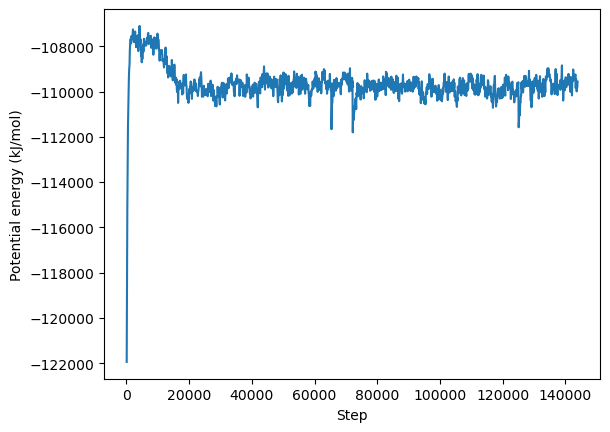

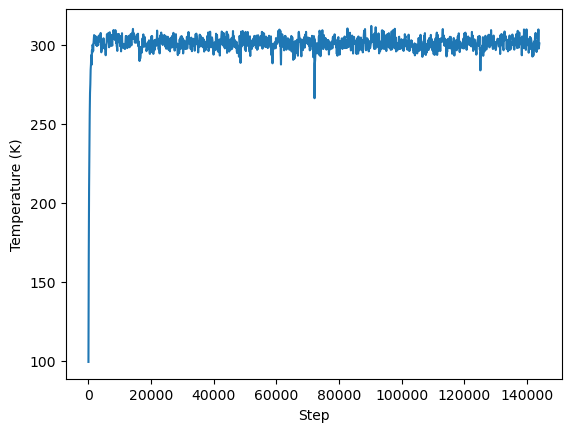

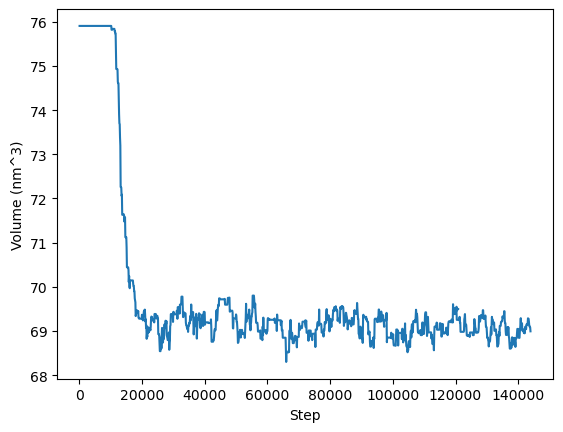

In [15]:
# we can redo the analysis on the longer trajectory

data = np.loadtxt('md_log.txt', delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()

